In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy.sql import label

from flask import Flask, jsonify

import matplotlib.pyplot as plt

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
Base = automap_base()

In [4]:
Base.prepare(engine, reflect=True)

In [5]:
Measurement = Base.classes.measurements
Station = Base.classes.stations

In [6]:
# linking python to db

session = Session(bind = engine)

In [7]:
# getting table names

inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [8]:
# measurement column names and types

columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date DATE
prcp FLOAT
tobs FLOAT


In [9]:
#station column names and types

columns = inspector.get_columns('stations')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
engine.execute('SELECT * FROM stations LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [11]:
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', 0.0, 73.0)]

In [12]:
# PRECIPITATION ANALYSIS
# Select prcp & date for the last 12 months
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2017-04-01')

In [13]:
data = {'date': [], 'prcp': []}

for row in results:
    data['date'].append(row.date)
    data['prcp'].append(row.prcp)

# create pandas df from dict
precip_12mo = pd.DataFrame(data['prcp'], columns = ['prcp'], index = data['date'])
print(precip_12mo.head())# Select prcp & date for the last 12 months


            prcp
2017-04-01   0.0
2017-04-02   0.0
2017-04-03   0.0
2017-04-04   0.0
2017-04-05   0.0


In [14]:
precip_12mo.head()

,prcp
2017-04-01,0.0
2017-04-02,0.0
2017-04-03,0.0
2017-04-04,0.0
2017-04-05,0.0


In [15]:

def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
print(calc_temps('2017-04-01', '2018-04-01'))

[(58.0, 76.45119047619048, 87.0)]


In [16]:
temperatures = (calc_temps('2017-04-01', '2018-04-01'))
labels = ['TMIN', 'TAVE', 'TMAX']
df = pd.DataFrame.from_records(temperatures, columns=labels)

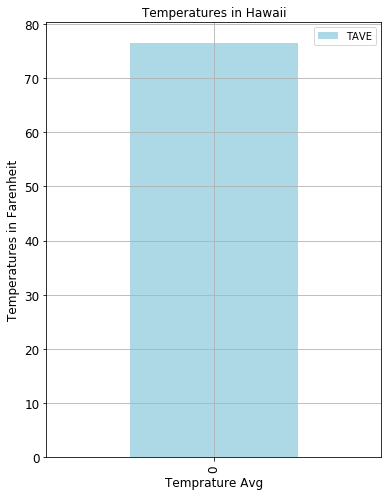

In [21]:
temp_chart = df[['TAVE']].plot(kind='bar', title ="Temperatures in Hawaii", figsize=(6, 8), legend=True, fontsize=12, grid=True, color='lightblue')
temp_chart.set_xlabel("Temprature Avg", fontsize=12)
temp_chart.set_ylabel("Temperatures in Farenheit", fontsize=12)
plt.show()

In [22]:
# STATION ANALYSIS
stations_results = session.query(func.count(Stations.station)).all()
print("There are " + str(stations_results[0]) + " stations.")

NameError: name 'Stations' is not defined

In [23]:
# Most active stations

active_results = session.query(Measurement.station,
    label('date', func.count(Measurement.date))).group_by(Measurement.station).all()
for result in active_results:
    print(result)

('USC00511918', 1979)
('USC00513117', 2709)
('USC00514830', 2202)
('USC00516128', 2612)
('USC00517948', 1372)
('USC00518838', 511)
('USC00519281', 2772)
('USC00519397', 2724)
('USC00519523', 2669)


In [24]:
#observation count in descending order

desc_order = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())
for result in desc_order:
    print(result)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [25]:
#station with the highest number of obervation

obsv_num = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print(obsv_num)

('USC00519281', 2772)


In [26]:
#last 12 months of temp obs data
temps = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date > '2017-04-01').\
    order_by(Measurement.date).all()
temps

[('USC00519397', datetime.date(2017, 4, 2), 76.0),
 ('USC00513117', datetime.date(2017, 4, 2), 74.0),
 ('USC00514830', datetime.date(2017, 4, 2), 77.0),
 ('USC00519523', datetime.date(2017, 4, 2), 79.0),
 ('USC00519281', datetime.date(2017, 4, 2), 75.0),
 ('USC00516128', datetime.date(2017, 4, 2), 71.0),
 ('USC00519397', datetime.date(2017, 4, 3), 77.0),
 ('USC00513117', datetime.date(2017, 4, 3), 73.0),
 ('USC00514830', datetime.date(2017, 4, 3), 77.0),
 ('USC00517948', datetime.date(2017, 4, 3), 75.0),
 ('USC00519523', datetime.date(2017, 4, 3), 76.0),
 ('USC00519281', datetime.date(2017, 4, 3), 70.0),
 ('USC00516128', datetime.date(2017, 4, 3), 73.0),
 ('USC00519397', datetime.date(2017, 4, 4), 76.0),
 ('USC00513117', datetime.date(2017, 4, 4), 72.0),
 ('USC00514830', datetime.date(2017, 4, 4), 76.0),
 ('USC00517948', datetime.date(2017, 4, 4), 75.0),
 ('USC00519523', datetime.date(2017, 4, 4), 78.0),
 ('USC00519281', datetime.date(2017, 4, 4), 67.0),
 ('USC00516128', datetime.date(

In [27]:
# station wih the highest number of observations

highest_obs = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.date > '2017-04-01').\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
highest_obs

[('USC00519397', 81.0),
 ('USC00516128', 76.0),
 ('USC00519523', 82.0),
 ('USC00519281', 79.0),
 ('USC00513117', 77.0),
 ('USC00514830', 82.0),
 ('USC00517948', 81.0)]

In [28]:
df = pd.DataFrame(temps, columns=['Station', 'date', 'temp'])
df.set_index('Station', inplace=True)
df.head()

,date,temp
Station,,
USC00519397,2017-04-02,76.0
USC00513117,2017-04-02,74.0
USC00514830,2017-04-02,77.0
USC00519523,2017-04-02,79.0
USC00519281,2017-04-02,75.0


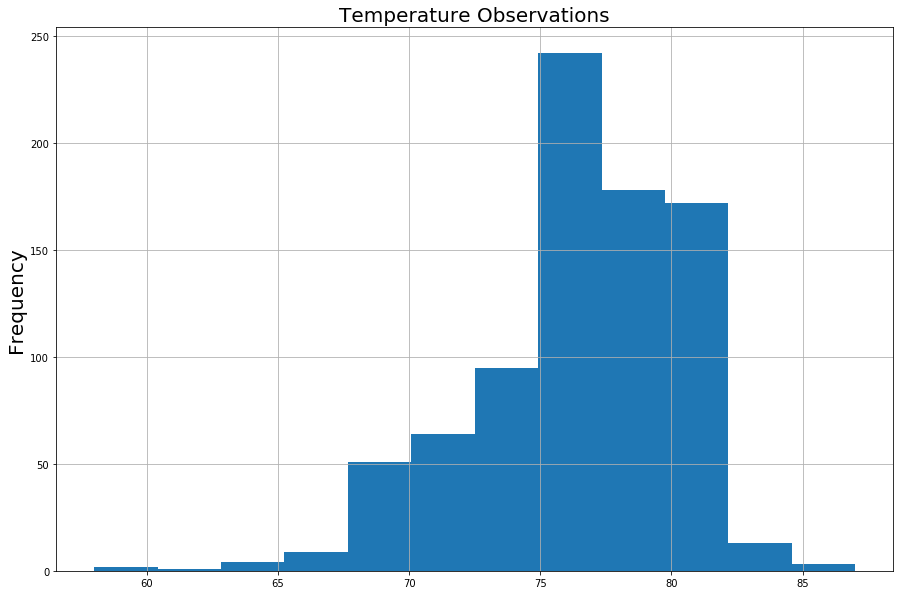

In [29]:
hist_plot = df['temp'].hist(bins=12, figsize=(15,10))
hist_plot.set_title('Temperature Observations', fontsize=20)
hist_plot.set_ylabel('Frequency', fontsize=20)
plt.show()

In [33]:
# Flask Setup
app = Flask(__name__)

In [34]:
@app.route("/")
def welcome1():
   
    return(
        f"Available Routes: <br/>"
        f"/api/v1.0/precipitation <br/>"
        f"/api/v1.0/stations <br/>"
        f"/api/v1.0/tobs <br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )

In [35]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    
# Query the database for dates and tobs
    prcp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > '2017-04-01').all()
  
    all_prcp = []
    for prcp in prcp_results:
        prcp_dict = {}
        prcp_dict["Date"] = Measurement.date
        prcp_dict["TOBS"] = Measurement.tobs
        all_prcp.append(prcp_dict)
    return jsonify(all_prcp)

In [36]:
@app.route("/api/v1.0/stations")
def stations():
    
    station_results = session.query(Station.station).all()
  
    all_stations = list(np.ravel(station_results))
    
    return jsonify(all_stations)

In [37]:
@app.route("/api/v1.0/tobs")
def tobs():
    
#Query database for tobs for last year
    tobs_results = session.query(Measurement.tobs).filter(Measurement.date > '2017-04-01').all()
  
    all_tobs = list(np.ravel(tobs_results))
    
    return jsonify(all_tobs)

In [38]:
if __name__ == '__main__':
    app.run(debug=True)

 * Restarting with stat


SystemExit: 1

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
